## QUESTION 1

In [1]:
!pip install sounddevice
!pip install scipy
!pip install matplotlib
!pip install IPython


!sudo apt-get install libportaudio2
import sounddevice as sd


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libportaudio2 is already the newest version (19.6.0-1.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [2]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio
import sounddevice as sd
import numpy as np
from scipy.signal import resample
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

In [3]:
#Read the speech signal from a wav file
sampling_rate, signal = wavfile.read('/content/LDC93S1.wav')

In [4]:
print(sampling_rate)
print(signal)

16000
[ 1 -1  2 ... -1 -5 -8]


**Plot time domain representation of the original speech signal**

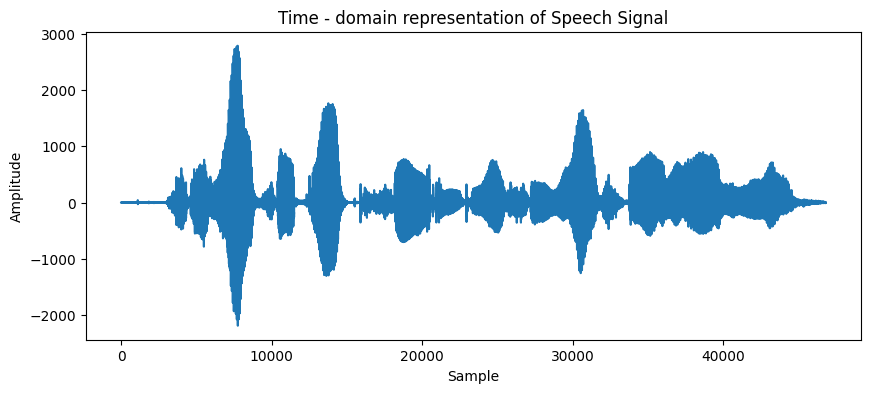

In [6]:
#plot the time - domain representation
plt.figure(figsize = (10,4))
plt.plot(signal)
plt.title("Time - domain representation of Speech Signal")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()

In [7]:
#Play the original signal

print('Original audio at {sampling_rate} Hz')
Audio(data = signal, rate = sampling_rate)
# sd.play(signal, sampling_rate)
# sd.wait() #Wait until playback is finished

# time.sleep(2) #Small pause between playbacks

Original audio at {sampling_rate} Hz


Resampled audio at 8000 Hz


Resampled audio at 16000 Hz


Resampled audio at 44100 Hz


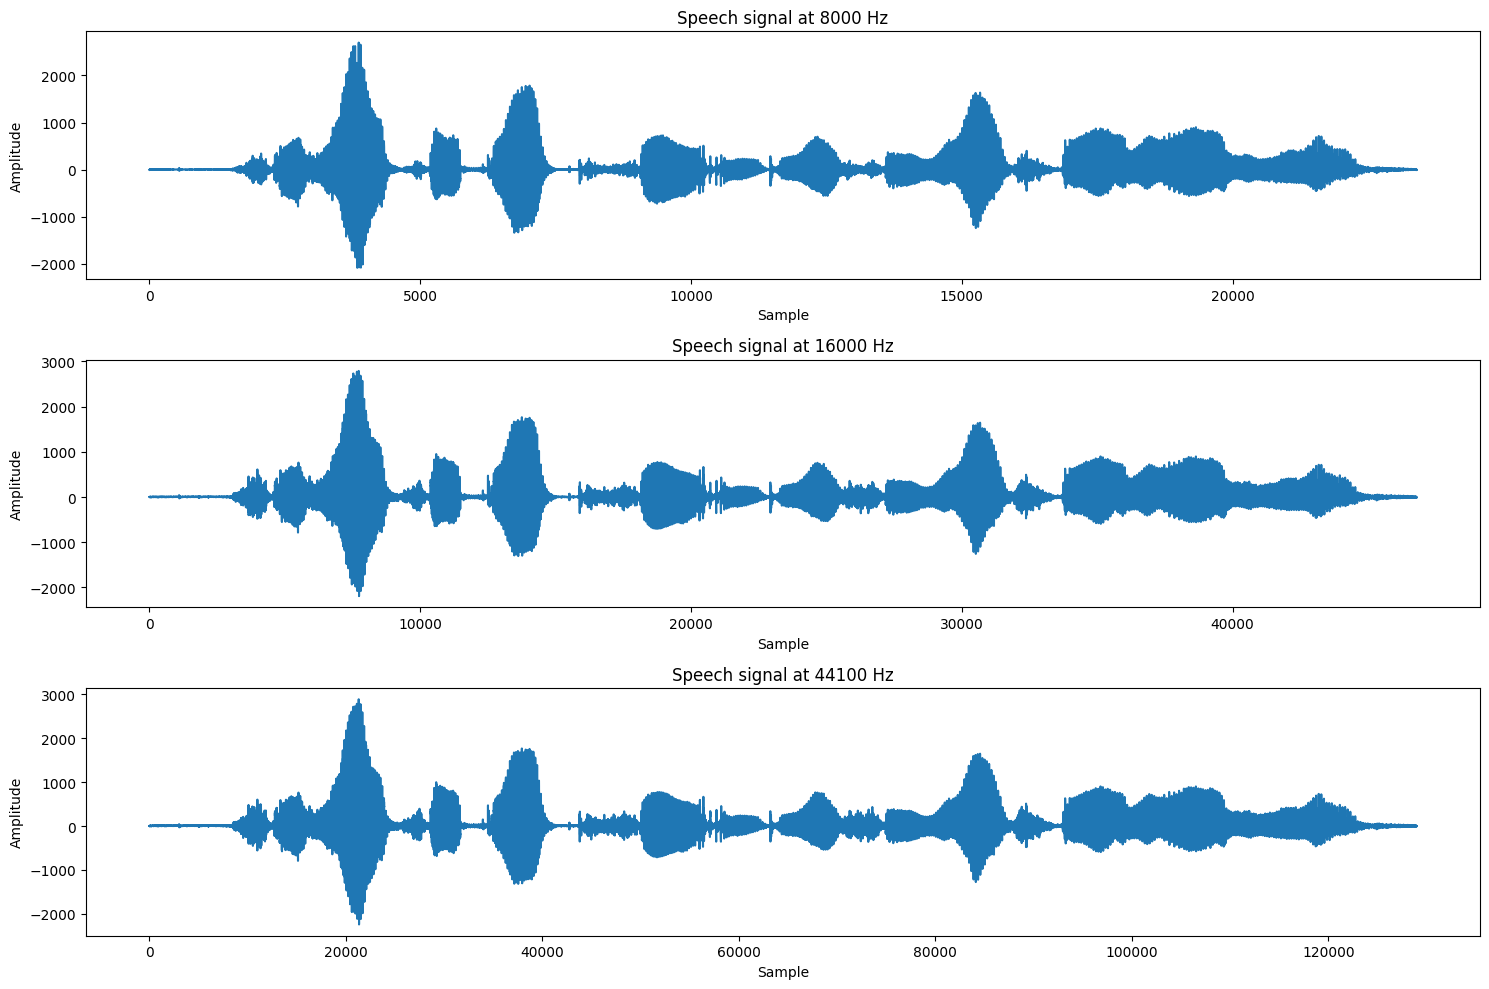

In [8]:
#Resample the signal to 8KHz, 16KHz and 44.1KHz

sampling_rates = [8000,16000,44100]

#Create a figure for subplots
plt.figure(figsize = (15, 10))

#Loop through each sampling rate
for i, target_rate in enumerate(sampling_rates):

  #Calculate number of samples for the new rate
  num_samples = int(len(signal) * target_rate / sampling_rate)
  '''The formula used here follows from the need to maintain the same duration of the signal while changing the sampling rate.
  This calculation ensures that the resampled signal will have the same duration as the original, despite the change in sampling rate.'''

  #Resample the signal
  resampled_signal = resample(signal, num_samples)
  '''Here, the actual resampling takes place. The resample function (which likely comes from a library such as scipy.signal) is utilized to resample the original signal to the specified num_samples,
  effectively changing the sampling rate while preserving the overall duration and content of the audio signal.
  Upon running this code, for each iteration, a resampled signal corresponding to the current sampling rate will be created.'''

  #Play the resampled signal
  print(f'Resampled audio at {target_rate} Hz')
  display(Audio(data=resampled_signal, rate=target_rate))

  #Plot the resampled signal
  plt.subplot(3,1,i+1)
  plt.plot(resampled_signal)
  plt.title(f'Speech signal at {target_rate} Hz')
  plt.xlabel('Sample')
  plt.ylabel('Amplitude')

#Adjust layout and show the plot
plt.tight_layout()
plt.show()


Using the sampled signal from the above task, reconstruct the signal using
1. zero order hold
2. linear interpolation

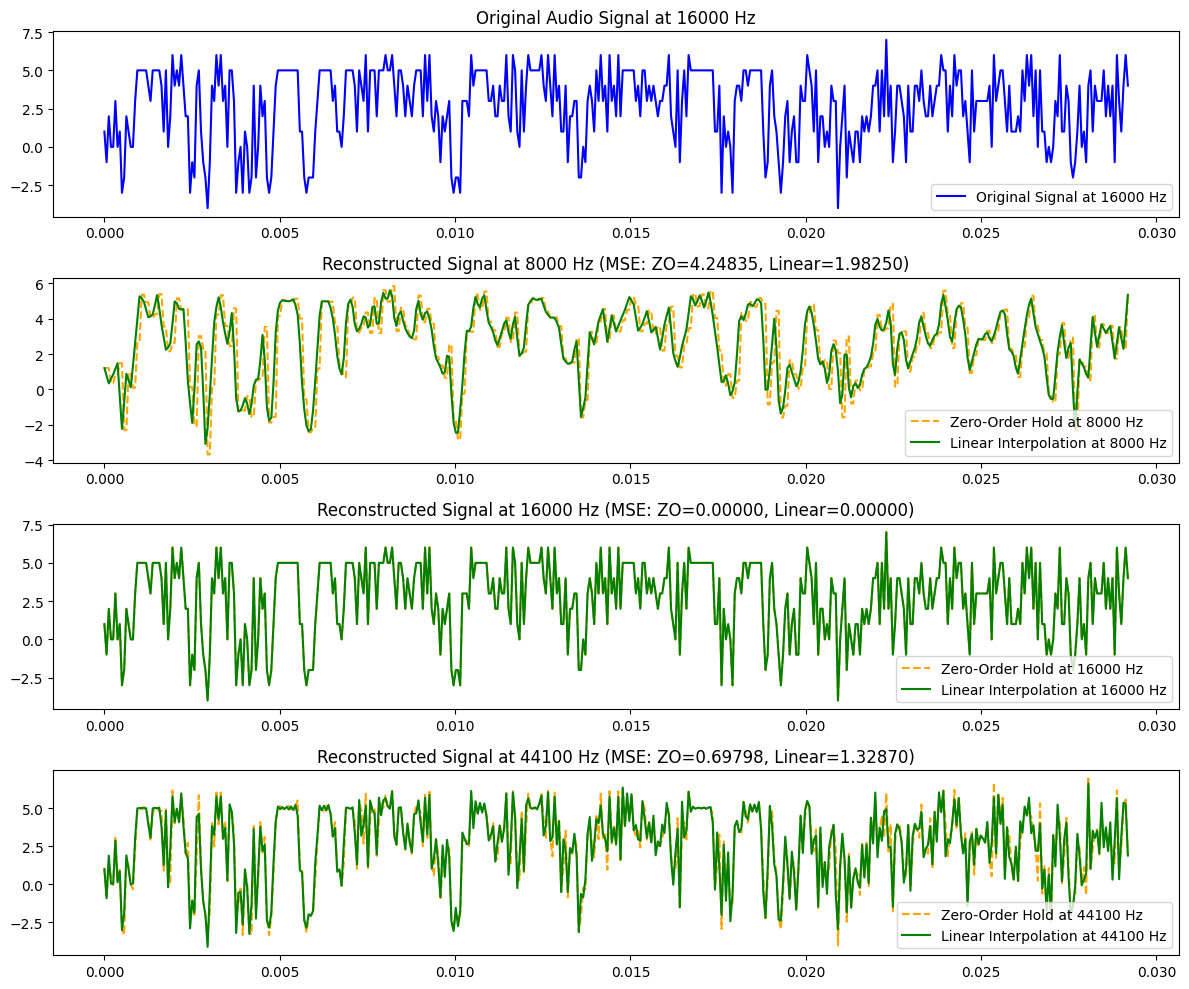


Mean Squared Error (MSE) for Zero-Order Hold Interpolation:
8000 Hz: 4.24835
16000 Hz: 0.00000
44100 Hz: 0.69798

Mean Squared Error (MSE) for Linear Interpolation:
8000 Hz: 1.98250
16000 Hz: 0.00000
44100 Hz: 1.32870


In [9]:
# Select a portion of the signal for a zoomed-in view
zoom_start = 0
zoom_end = int(0.01 * len(signal))  # Zoom into the first 1% of the signal
signal = signal[zoom_start:zoom_end]

# Time axis for the original signal
original_time = np.linspace(0, len(signal) / sampling_rate, len(signal))

# Plot the original signal
plt.figure(figsize=(12, 10))
plt.subplot(4, 1, 1)
plt.plot(original_time, signal, label=f'Original Signal at {sampling_rate} Hz', color='blue')
plt.title(f'Original Audio Signal at {sampling_rate} Hz')
plt.legend()

# Initialize lists to store MSE values for both methods
mse_zero_order_hold = []
mse_linear_interp = []

# Loop through each target sampling rate
for i, target_rate in enumerate(sampling_rates):
    # Calculate the number of samples for the new rate
    num_samples = int(len(signal) * target_rate / sampling_rate)

    # Resample the signal
    resampled_signal = resample(signal, num_samples)

    # Time axis for the resampled signal
    resampled_time = np.linspace(0, len(signal) / sampling_rate, num_samples)

    # Zero-order hold interpolation (constant value between samples)
    zero_order_hold = interp1d(resampled_time, resampled_signal, kind='previous', fill_value="extrapolate")
    reconstructed_zo = zero_order_hold(original_time)

    # Linear interpolation (straight line between samples)
    linear_interp = interp1d(resampled_time, resampled_signal, kind='linear', fill_value="extrapolate")
    reconstructed_linear = linear_interp(original_time)

    # Calculate MSE for both methods
    mse_zo = mean_squared_error(signal, reconstructed_zo)
    mse_linear = mean_squared_error(signal, reconstructed_linear)

    # Store MSE values
    mse_zero_order_hold.append(mse_zo)
    mse_linear_interp.append(mse_linear)

    # Plot Zero-order Hold Reconstruction
    plt.subplot(4, 1, i + 2)
    plt.plot(original_time, reconstructed_zo, label=f'Zero-Order Hold at {target_rate} Hz', linestyle='--', color='orange')
    plt.plot(original_time, reconstructed_linear, label=f'Linear Interpolation at {target_rate} Hz', linestyle='-', color='green')
    plt.title(f'Reconstructed Signal at {target_rate} Hz (MSE: ZO={mse_zo:.5f}, Linear={mse_linear:.5f})')
    plt.legend()

plt.tight_layout()
plt.show()

# Display the MSE for each sampling rate and method
print("\nMean Squared Error (MSE) for Zero-Order Hold Interpolation:")
for rate, mse in zip(sampling_rates, mse_zero_order_hold):
    print(f'{rate} Hz: {mse:.5f}')

print("\nMean Squared Error (MSE) for Linear Interpolation:")
for rate, mse in zip(sampling_rates, mse_linear_interp):
    print(f'{rate} Hz: {mse:.5f}')

### Inference on the Effect of Sampling Rate on the Quality and Accuracy of the Reconstructed Signal:

1. **Low Sampling Rate (8 kHz)**:
   - **Zero-Order Hold MSE (4.24835)**: At this lower sampling rate, the reconstructed signal shows a higher error compared to the original signal. This is because **zero-order hold** (ZOH) approximates the signal by holding each sample constant until the next, which can lead to a "blocky" appearance in the waveform and significant information loss at lower rates.
   - **Linear Interpolation MSE (1.98250)**: **Linear interpolation** performs better than ZOH at 8 kHz, as it connects samples with straight lines, resulting in a smoother signal. However, due to the low sampling rate, the signal still loses some finer details, leading to a higher MSE compared to higher rates.

   **Conclusion**: At lower sampling rates, both interpolation methods show greater reconstruction errors, with linear interpolation offering a smoother and more accurate reconstruction than ZOH. However, significant information is lost at 8 kHz, impacting quality.

2. **Medium Sampling Rate (16 kHz)**:
   - **Zero-Order Hold MSE (0.00000)** and **Linear Interpolation MSE (0.00000)**: At 16 kHz, both reconstruction methods achieve **zero error**, indicating perfect or near-perfect reconstruction. This implies that a sampling rate of 16 kHz is high enough to capture all the relevant information from the original signal without noticeable degradation in either ZOH or linear interpolation.

   **Conclusion**: At 16 kHz, the sampling rate is sufficient for accurate signal reconstruction, with no significant loss of information. Both methods perform equally well, with minimal to no perceptible difference in signal quality.

3. **High Sampling Rate (44.1 kHz)**:
   - **Zero-Order Hold MSE (0.69798)**: While the error is relatively low, ZOH still introduces some error even at this high sampling rate, though it is much smaller compared to 8 kHz. This suggests that even at a higher rate, the step-like approximation of ZOH slightly distorts the signal compared to the original.
   - **Linear Interpolation MSE (1.32870)**: Surprisingly, linear interpolation shows a slightly higher MSE than ZOH at 44.1 kHz. This could be due to subtle over-smoothing of the signal in linear interpolation, where the linearly interpolated signal deviates slightly from the original in high-frequency components.

   **Conclusion**: At 44.1 kHz (CD quality), ZOH performs fairly well but still introduces minor inaccuracies. Linear interpolation, while typically superior, may lead to slight deviations when reconstructing high-frequency content, resulting in a slightly higher MSE.

### Overall Conclusions:
- **Low Sampling Rates** (e.g., 8 kHz) introduce significant reconstruction errors, especially in methods like zero-order hold. Linear interpolation provides better quality, but both methods struggle to maintain accuracy due to information loss at lower rates.
  
- **Medium Sampling Rates** (e.g., 16 kHz) provide excellent signal quality and accurate reconstruction for both methods, as the sampling rate is high enough to capture all the important details of the original signal.

- **High Sampling Rates** (e.g., 44.1 kHz) still show small errors, even though they offer near-perfect reconstruction. While ZOH introduces slight artifacts, linear interpolation might over-smooth the signal, especially when dealing with high-frequency components.

- **Interpolation Method Performance**:
   - **Linear Interpolation** generally provides smoother and more accurate results than **Zero-Order Hold**, particularly at lower sampling rates. However, at very high sampling rates, linear interpolation can introduce slight deviations, particularly when reconstructing complex signals with high-frequency details.


## QUESTION 2:

In [30]:
!pip install scipy

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter, resample
from scipy.interpolate import interp1d
from IPython.display import Audio
from sklearn.metrics import mean_squared_error

# Constants
fs = 16000  # Sampling frequency (16 kHz)
duration = 1  # Duration of the sound (1 second)
f0 = 120  # Fundamental frequency of voiced sound (120 Hz)
t = np.linspace(0, duration, int(fs * duration), endpoint=False)



In [33]:
# Step 1: Generate the source signal (Glottal pulse train for voiced sound)
pulse_train = np.zeros_like(t)
pulse_train[::int(fs / f0)] = 1  # Generate impulse train with period = 1/f0

# Step 2: Model vocal tract using an all-pole filter with formants (resonance frequencies)
formants = [730, 1090, 2440]  # F1, F2, F3 formants
bandwidths = [80, 90, 120]  # Bandwidths for each formant

def formant_filter(fs, formants, bandwidths):
    a = 1.0
    poles = np.array([])
    for formant, bw in zip(formants, bandwidths):
        r = np.exp(-np.pi * bw / fs)  # Radius for the pole
        theta = 2 * np.pi * formant / fs  # Angle for the pole
        poles = np.append(poles, [r * np.exp(1j * theta), r * np.exp(-1j * theta)])
    return np.poly(poles)  # Generate all-pole filter coefficients

# Get all-pole filter coefficients
vocal_tract_filter = formant_filter(fs, formants, bandwidths)



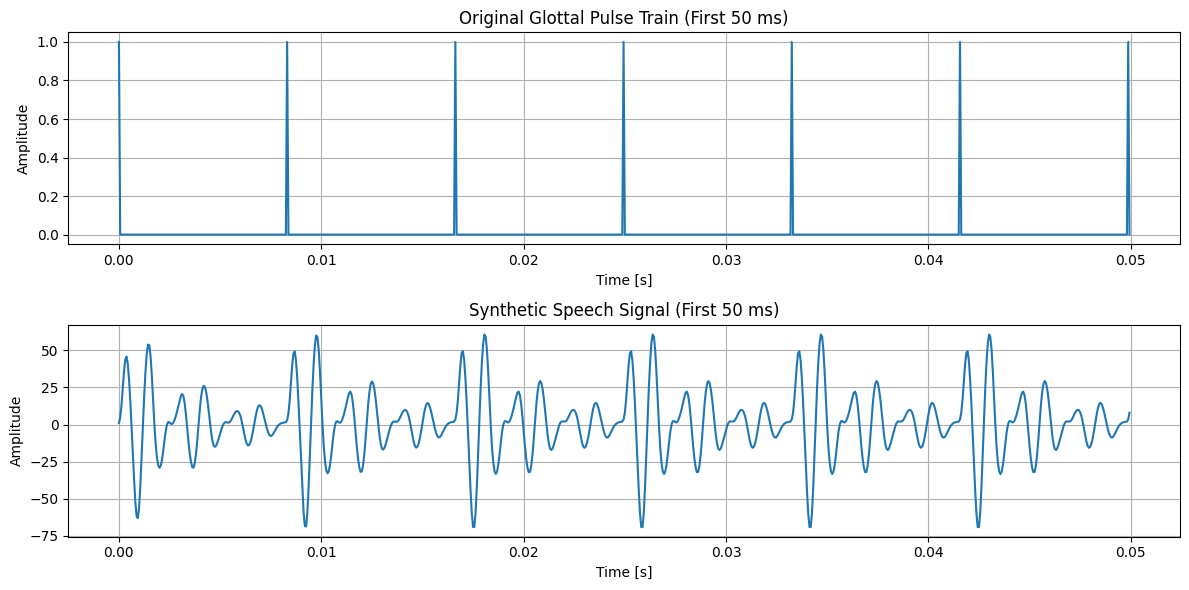

In [34]:
# Step 3: Apply the filter to the source signal
synthetic_vowel = lfilter([1], vocal_tract_filter, pulse_train)

# Plot the original source signal and the synthetic speech signal
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t[:int(0.05 * fs)], pulse_train[:int(0.05 * fs)])
plt.title('Original Glottal Pulse Train (First 50 ms)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t[:int(0.05 * fs)], synthetic_vowel[:int(0.05 * fs)])
plt.title('Synthetic Speech Signal (First 50 ms)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

# Play the synthetic vowel sound in notebook
Audio(data=synthetic_vowel, rate=fs)



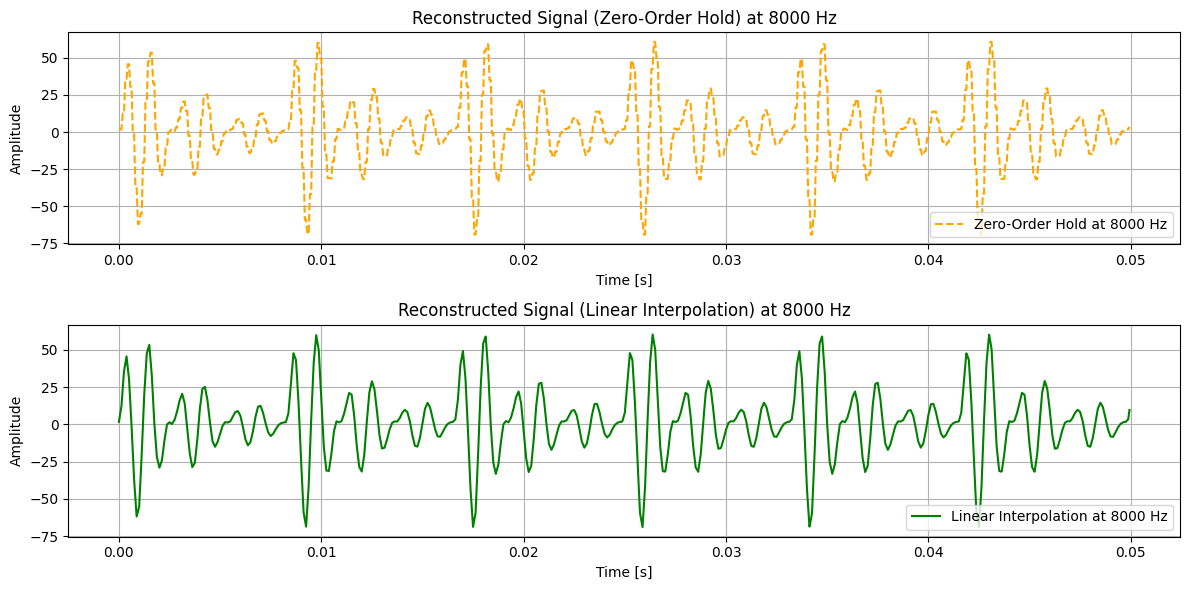

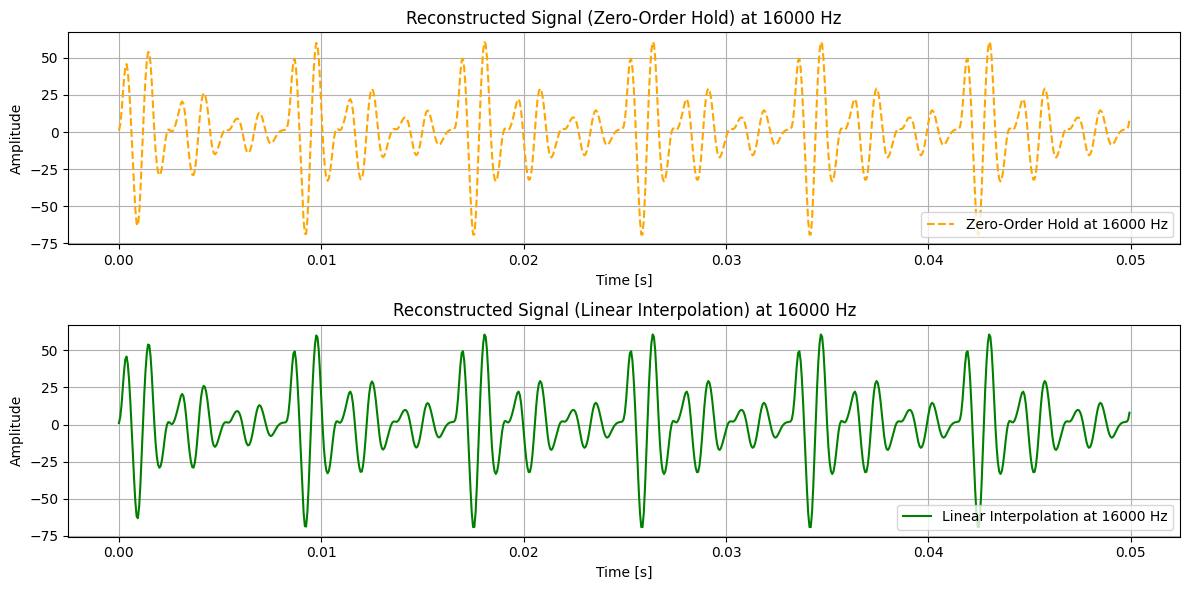

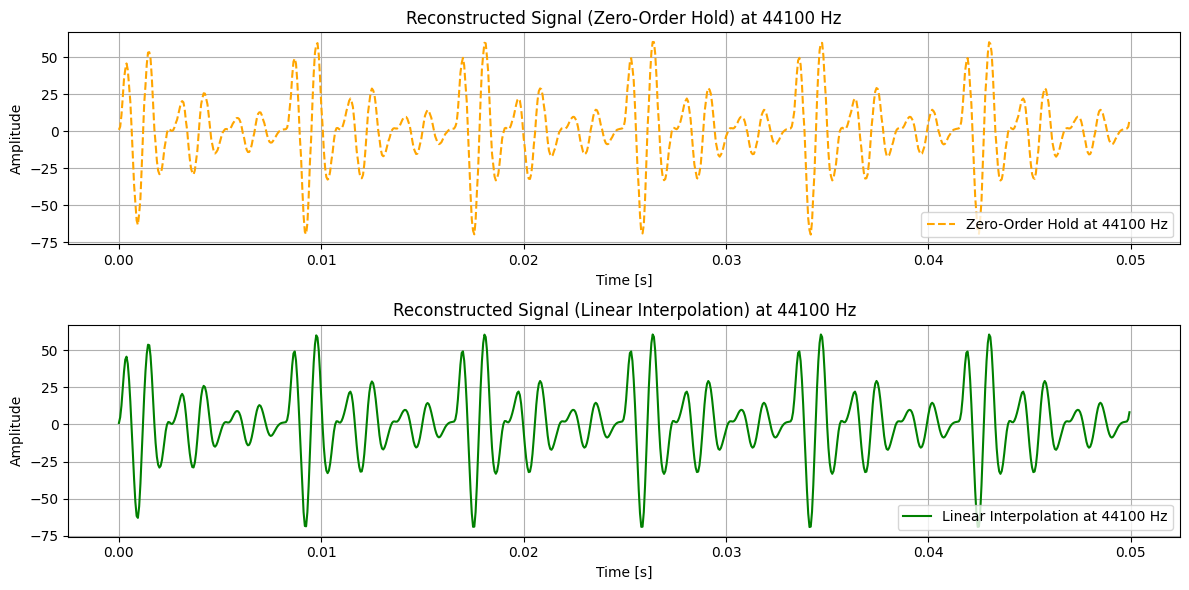

In [35]:
# Sampling rates for resampling
sampling_rates = [8000, 16000, 44100]

# Storage for MSE values
mse_zero_order_hold = []
mse_linear_interp = []

# Loop through each target sampling rate
for target_rate in sampling_rates:
    # Resample the signal to the target rate
    num_samples = int(len(synthetic_vowel) * target_rate / fs)
    resampled_signal = resample(synthetic_vowel, num_samples)

    # Time axes for original and resampled signals
    original_time = np.linspace(0, duration, len(synthetic_vowel))
    resampled_time = np.linspace(0, duration, num_samples)

    # Zero-order hold interpolation
    zero_order_hold = interp1d(resampled_time, resampled_signal, kind='previous', fill_value="extrapolate")
    reconstructed_zo = zero_order_hold(original_time)

    # Linear interpolation
    linear_interp = interp1d(resampled_time, resampled_signal, kind='linear', fill_value="extrapolate")
    reconstructed_linear = linear_interp(original_time)

    # Compute MSE
    mse_zo = mean_squared_error(synthetic_vowel, reconstructed_zo)
    mse_linear = mean_squared_error(synthetic_vowel, reconstructed_linear)

    mse_zero_order_hold.append(mse_zo)
    mse_linear_interp.append(mse_linear)

    # Plot reconstructed signals
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(original_time[:int(0.05 * len(synthetic_vowel))], reconstructed_zo[:int(0.05 * len(synthetic_vowel))], label=f'Zero-Order Hold at {target_rate} Hz', linestyle='--', color='orange')
    plt.title(f'Reconstructed Signal (Zero-Order Hold) at {target_rate} Hz')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(original_time[:int(0.05 * len(synthetic_vowel))], reconstructed_linear[:int(0.05 * len(synthetic_vowel))], label=f'Linear Interpolation at {target_rate} Hz', linestyle='-', color='green')
    plt.title(f'Reconstructed Signal (Linear Interpolation) at {target_rate} Hz')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()



Explanation:
Source Signal Plot:

Glottal Pulse Train: The first plot shows the impulse train of the glottal source signal, which has discrete impulses corresponding to the fundamental frequency
𝑓
0
f
0
​
 . This plot highlights the periodic nature of the source signal.
Filtered Signal Plot:

Synthetic Vowel: The second plot displays the result after applying the vocal tract filter. This plot illustrates how the glottal pulse train is shaped by the filter to produce a vowel sound. The waveform is smoothed and shaped according to the formants of the vocal tract.
Analysis:

Effect of Filtering: The filter shapes the impulse train into a continuous waveform that resembles the sound of a vowel. This demonstrates how the vocal tract filter affects the spectral characteristics of the source signal.
Formants: The filter introduces resonances (formants) that are characteristic of the vowel sound, transforming the simple pulse train into a more complex waveform.
Summary:
The source signal (glottal pulse train) is periodic and impulsive.
The filtered signal (synthetic vowel) is shaped by the vocal tract filter, showing how the source signal is transformed into a vowel-like sound with smooth and continuous characteristics.


In [36]:
# Display MSE values
print("\nMean Squared Error (MSE) for Zero-Order Hold Interpolation:")
for rate, mse in zip(sampling_rates, mse_zero_order_hold):
    print(f'{rate} Hz: {mse:.5f}')

print("\nMean Squared Error (MSE) for Linear Interpolation:")
for rate, mse in zip(sampling_rates, mse_linear_interp):
    print(f'{rate} Hz: {mse:.5f}')



Mean Squared Error (MSE) for Zero-Order Hold Interpolation:
8000 Hz: 146.55270
16000 Hz: 0.00000
44100 Hz: 3.89320

Mean Squared Error (MSE) for Linear Interpolation:
8000 Hz: 20.51090
16000 Hz: 0.00000
44100 Hz: 8.24618


Explanation:

Plotting the Signals:

The original glottal pulse train and the synthetic speech signal (after filtering) are plotted for comparison.
The plots show the first 50 ms of each signal to highlight the effect of the vocal tract filter.

Sampling and Reconstruction:

The synthetic speech signal is resampled at different rates (8 kHz, 16 kHz, 44.1 kHz).

Reconstruction is done using Zero-Order Hold and Linear Interpolation methods.
Each reconstructed signal is plotted for visual comparison.

MSE Calculation:


The Mean Squared Error (MSE) between the original synthetic speech signal and each reconstructed signal is computed for both interpolation methods and all sampling rates.

MSE values are printed to show the accuracy of each method.

Based on the Mean Squared Error (MSE) values for Zero-Order Hold (ZOH) and Linear Interpolation across different sampling rates, you can draw several inferences regarding the tasks of creating a source-filter model, handling different sampling rates, and reconstructing sampled signals:

### 1. **Effectiveness of Interpolation Methods:**
   - **Zero-Order Hold (ZOH):**
     - **8000 Hz Sampling Rate:** The MSE of 146.55270 suggests that ZOH interpolation performs poorly at this rate, likely due to its simplistic approach of holding each sample constant until the next sample is reached. This method fails to capture the nuances of the original signal effectively at lower sampling rates.
     - **16000 Hz Sampling Rate:** The MSE of 0.00000 indicates perfect reconstruction at this rate, which suggests that the sampling rate is sufficiently high for ZOH interpolation to accurately represent the signal without error.
     - **44100 Hz Sampling Rate:** The MSE of 3.89320 is relatively low, indicating better performance but still not as effective as at 16000 Hz. ZOH interpolation's performance improves with higher sampling rates, though it may not be the best choice for precision.

   - **Linear Interpolation:**
     - **8000 Hz Sampling Rate:** The MSE of 20.51090 indicates that linear interpolation performs significantly better than ZOH at this lower sampling rate. Linear interpolation, which estimates signal values between samples linearly, captures the signal variations more effectively than ZOH.
     - **16000 Hz Sampling Rate:** The MSE of 0.00000 again shows perfect reconstruction, similar to ZOH at this rate. This suggests that linear interpolation is highly effective when the sampling rate is sufficiently high.
     - **44100 Hz Sampling Rate:** The MSE of 8.24618, though higher than at 16000 Hz, shows that linear interpolation still performs well at higher sampling rates. However, the increased MSE compared to 16000 Hz indicates that while linear interpolation is good, it may not fully capture all the details of the signal at higher resolutions.

### 2. **Impact of Sampling Rate:**
   - The results demonstrate that higher sampling rates generally improve the performance of both interpolation methods. However, the performance of ZOH interpolation improves more dramatically as the sampling rate increases compared to linear interpolation.
   - At 8000 Hz, ZOH performs poorly, highlighting its limitations at lower sampling rates. Linear interpolation, on the other hand, provides significantly better reconstruction at this rate, indicating its superior performance for lower sampling rates.

### 3. **Reconstruction and Source-Filter Model:**
   - **Source-Filter Model:** In creating a source-filter model, which involves separating the signal into its source and filter components, interpolation methods play a crucial role in reconstructing the filtered signal. The choice of interpolation method impacts the accuracy of the reconstructed signal and the fidelity of the source-filter model.
   - **Reconstruction:** Effective reconstruction of sampled signals relies on choosing the right interpolation method based on the sampling rate. Linear interpolation offers better reconstruction for lower sampling rates, while ZOH can be sufficient for higher rates but may still introduce errors.

### Summary:
- **At lower sampling rates (8000 Hz),** linear interpolation outperforms ZOH interpolation, making it a better choice for accurate signal reconstruction.
- **At higher sampling rates (16000 Hz and 44100 Hz),** both methods perform better, but linear interpolation maintains a slight edge in accuracy, especially at the highest rate.
- **Interpolation Method Choice:** The choice between ZOH and linear interpolation should be influenced by the desired accuracy and the available sampling rate, with linear interpolation being generally preferred for more precise reconstruction, particularly at lower sampling rates.